# Peer-graded Assignment: Week 3: CNN Cancer Detection Kaggle Mini-Project

#### Prepared by: Alejandro Zuniga Luna

This mini-project is for de peer-graded assigment of thw week 3 course Introduction to deep learnig from the University of Colorado Bourler.

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as tf
import visualkeras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Brief description of the problem and data

It is needed an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. Kaggle competition [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) will be used. This is a binary image classification problem where we will identify metastatic cancer in small image patches taken from larger digital pathology scan.

This dataset is a large number of small pathology images to classify. Files are named with an image id. There is a file with the labels that provides the ground truth for the images in the train folder. A prediction will be made for the images in the test folder. 

A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.



## 2. Exploratory Data Analysis (EDA)

#### Inspect, Visualize and Clean the Data

The information is obtained from the train_labels.csv file. In the ID column we find the identification of the respective image, while in LABEL column we will have 0 if the identification is negative and 1 if it is positive.

In [108]:
y_train = pd.read_csv("files/train_labels.csv")
y_train['label'] = y_train['label'].astype(str)
y_train['id'] = y_train['id'] + '.tif'
y_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [109]:
num_train = len(y_train)
num_train

220025

According to the length of this dataframe, the train directory have a total of 220025 images. Observe sample images from the train directory. Each image as a size of 96 x 96 pixels with three color layers. 

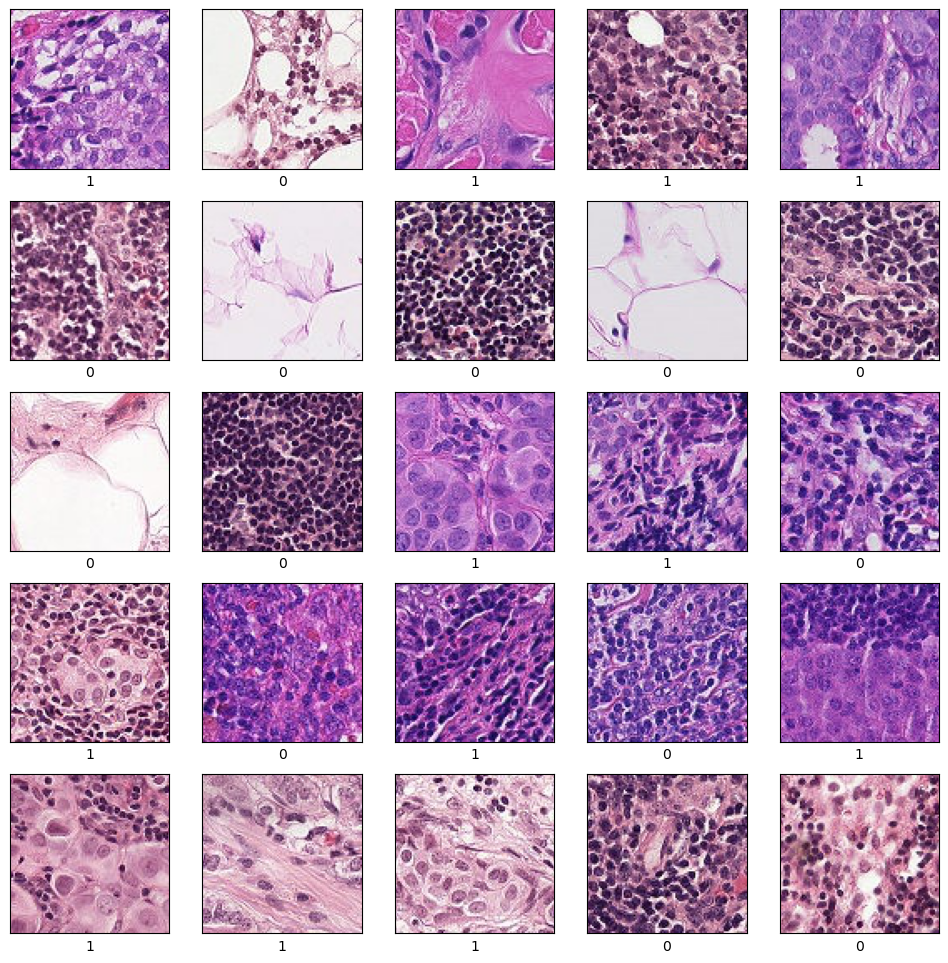

In [128]:
indexes = np.random.randint(0, len(y_train), size=25)
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
for i, axis in enumerate(ax.flat):
    image = tf.utils.load_img("train/" + y_train["id"][indexes[i]] )
    axis.imshow(image)
    axis.set(xticks=[], yticks=[], xlabel = y_train.label[indexes[i]]);

In [127]:
input_arr = tf.utils.img_to_array(image)
input_arr.shape

(96, 96, 3)

There is also a directory with 57458 images for testing porposes.

In [106]:
y_test = pd.read_csv("files/sample_submission.csv")
y_test['label'] = y_test['label'].astype(str)
y_test['id'] = y_test['id'] + '.tif'
y_test.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [44]:
num_test = len((y_test))
num_test

57458

When we run a describe method, we observe that initially all samples are negatively identify. Our task is to identify the bst we could the rigth label. 

In [45]:
y_test.describe()

,label
count,57458.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


First we must identify if we have a balance between categories. We make a plot from the total images in the train directory. Notice that there is no 50% distribution, but there are enough samples from both categories to make the prediction. 


<Axes: xlabel='label'>

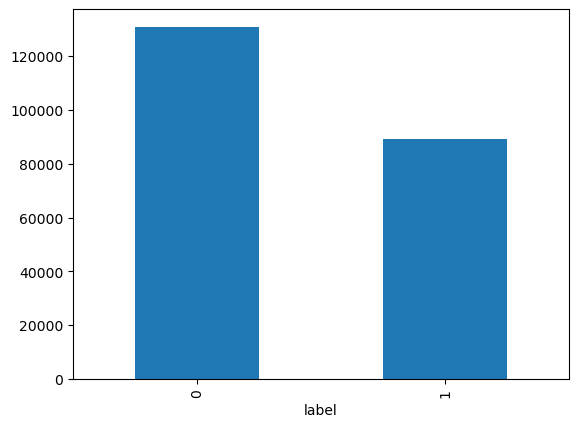

In [84]:
total_train = y_train.groupby("label").count()

total_train["id"].plot.bar()

## 3. DModel Architecture

For the training process, we are going to split the images by 20% for validation and the rest for train. Because we have images in tif format, we are going to use ImageDataGenerator method, although it is obsolete. This is because the new method  tf.keras.utils.image_dataset_from_directory is not compatible with tif format. 

I use the recomendations of [Tutorial on Keras flow_from_dataframe](https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c) for the preprocessing of the image data for train, validate and test. 

In [158]:
batch_size = 256
image_size = (96,96)
dir_train = "train/"
dir_test = "test/"


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
        dataframe = y_train,
        target_size = image_size,
        batch_size=batch_size,
        directory = dir_train,
        x_col = "id",
        y_col = "label",
        subset = "training",
        class_mode = "binary",
        seed=42,
        shuffle=True)
validation_generator = train_datagen.flow_from_dataframe(
        dataframe = y_train,
        target_size = image_size,
        batch_size=batch_size,
        directory = dir_train,
        x_col = "id",
        y_col = "label",
        subset = "validation",
        class_mode = "binary",
        seed=42,
        shuffle=True)

test_generator=test_datagen.flow_from_dataframe(
        dataframe=y_test,
        directory="test/",
        x_col="id",
        y_col=None,
        batch_size=50,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=image_size)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


For the model arquitecture I going to start in a simple model, with the componentes describe by Geena Kim in the week 3 lectures.  

![](images/typicakCNNarquitecture.png)

Also I will include some recommendations of the Convolutional Neural network presented in the book __Advanced Deep Learning with TensorFlow 2 and Keras__ from _Rowel Atienza_ to solve the MNIST digit classification problem. 

First we define some network parameters.


In [168]:
input_shape = (96,96,3)
kernel_size = 3
pool_size   = 2
filters     = 64
dropout     = 0.2

Second the network model.

In [170]:
model = Sequential()
model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation="relu", input_shape=input_shape))
model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation="relu"))
model.add(MaxPooling2D(pool_size))
model.add(Flatten())
# dropout addes as regularizer
model.add(Dropout(dropout))
#output layer is 10-dim one-hot vector
model.add(Dense(1))
model.add(Activation("sigmoid"))

We can check the arqutecture of the model. 

In [172]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 94, 94, 64)        1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 92, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 135424)            0         
                                                                 
 dropout (Dropout)           (None, 135424)            0         
                                                                 
 dense (Dense)               (None, 1)                 135425    
                                                      

Also we can add some visual representation of the model.

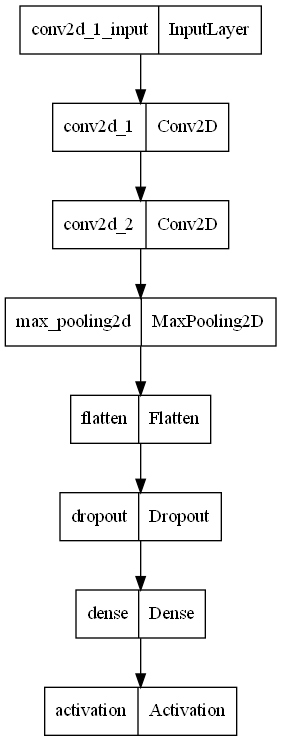

In [181]:
plot_model(model)

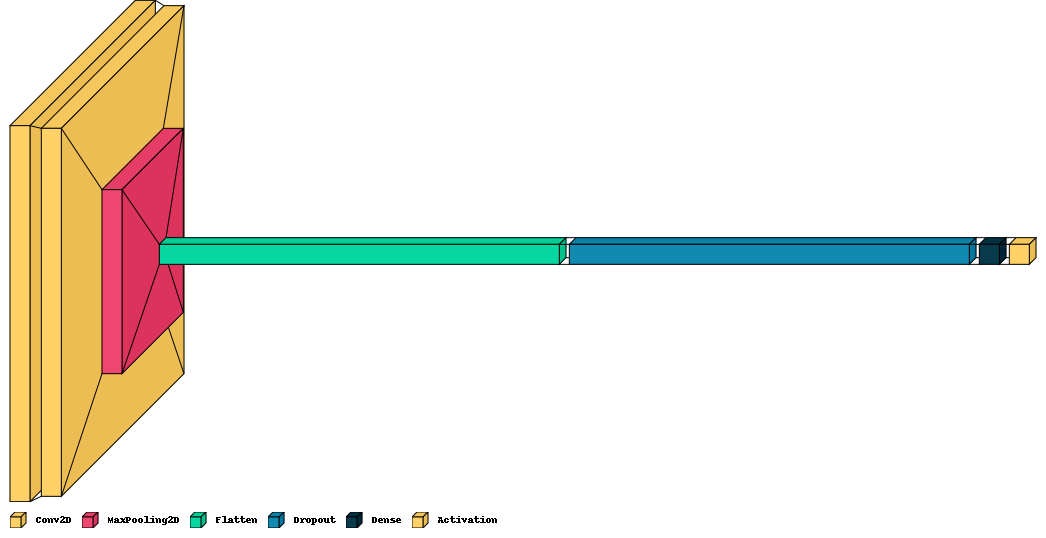

In [182]:
visualkeras.layered_view(model, legend=True)

According to the results obtained from the first training, convolutional layers will be added and hyperparameter will be changed to search for better results.

For the optimization process we will use "adam" algorthm and for loss calculation use the binary crossentropy. It is recommended to use accuracy for classification problems. 

In [184]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

## 4. Results and Analysis 

We test our fert fit process using the train and validation data generated befor with the ImageDataGeneration.


In [205]:
# train the network 
hist = model.fit(train_generator, epochs=10, batch_size=batch_size)

Epoch 1/10
688/688 [==============================] - 1905s 3s/step - loss: 0.4244 - accuracy: 0.8091
Epoch 2/10
688/688 [==============================] - 1861s 3s/step - loss: 0.3917 - accuracy: 0.8276
Epoch 3/10
688/688 [==============================] - 1844s 3s/step - loss: 0.3601 - accuracy: 0.8446
Epoch 4/10
688/688 [==============================] - 1885s 3s/step - loss: 0.3355 - accuracy: 0.8570
Epoch 5/10
688/688 [==============================] - 1926s 3s/step - loss: 0.3176 - accuracy: 0.8667
Epoch 6/10
688/688 [==============================] - 1954s 3s/step - loss: 0.2994 - accuracy: 0.8752
Epoch 7/10
688/688 [==============================] - 1938s 3s/step - loss: 0.2892 - accuracy: 0.8796
Epoch 8/10
688/688 [==============================] - 2758s 4s/step - loss: 0.2772 - accuracy: 0.8859
Epoch 9/10
688/688 [==============================] - 4263s 6s/step - loss: 0.2658 - accuracy: 0.8906
Epoch 10/10
688/688 [==============================] - 3853s 6s/step - loss: 0.255

We can plot de loss function to know how the model behaves in each epoch.

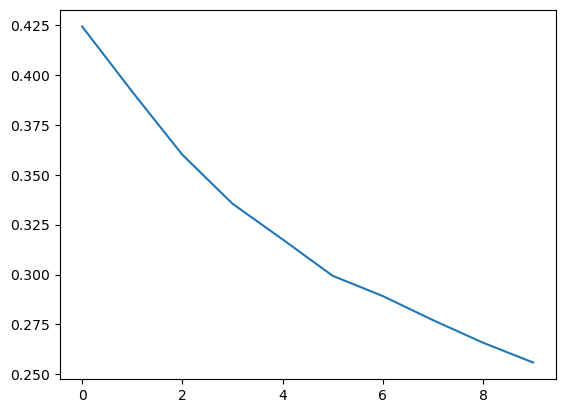

In [206]:
plt.plot(hist.history['loss'])

Next, we evaluate the model with the test data to calculate our accuracy. 

In [207]:
_, acc = model.evaluate(validation_generator,batch_size = batch_size, verbose=1)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

172/172 [==============================] - 235s 1s/step - loss: 0.3515 - accuracy: 0.8564

Test accuracy: 85.6%


With these results we can try to submit our prediction to the competition. 

In [208]:
predictions = model.predict(test_generator, verbose=1)

1150/1150 [==============================] - 327s 283ms/step


In [209]:
submission_files = pd.read_csv("files/sample_submission.csv")
files_name = submission_files["id"]
final_predictions = np.transpose(np.where(predictions>0.5,1,0))[0]
submission = pd.DataFrame(list(zip(files_name,final_predictions)), columns=["id", "label"])
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


Finally, we have to prepare the submission file to compare our results with other competition results. 

In [210]:
submission.to_csv('files/submission.csv', index=False)

## 5. Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

## Public project GitHub repository